PVLIB Python es una herramienta creada por la comunidad, que proporciona un conjunto de funciones y clases para simular el rendimiento de los sistemas de energía fotovoltaica.

# Requerimentos

In [ ]:
## en caso de no tener instalados, correr el siguiente codigo:

################## PVLIB ##################
#---------------------------------------------
!pip install pvlib
#---------------------------------------------

     |████████████████████████████████| 27.6 MB 20.0 MB/s 


In [ ]:
# pandas es una libreria para manipulacion de datos
import pandas as pd

# pvlib es la libreria requerida para extraer datos
import pvlib

# numpy se utiliza para operaciones aritmeticas
import numpy as np 

# librería requerida para escribir archivos pickle
import pickle

# Librerías de visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librería para estandarizar
from sklearn.preprocessing import StandardScaler
from numpy.core.multiarray import concatenate

In [ ]:
# Conectar con google drive (Es necesario tener la carpeta compartida "PV")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación de datos


## Plantas de producción eléctrica

In [ ]:
PV = pd.read_csv('/content/drive/Shareddrives/PV/data/CELLCODE_PV_count.csv', index_col = 0) 

In [ ]:
PV.head(2)

,CELLCODE,Ph_count,N,E,Lat,Lng
0,1kmE4009N2567,7.0,2567.5,4009.5,46.144585,5.970790
1,1kmE4009N2568,9.0,2568.5,4009.5,46.153577,5.970117


# Sampleo

In [ ]:
def n1(x_1, x_2, y_1, y_2):
    return abs(x_1 - y_1) + abs(x_2 - y_2)

In [ ]:
def get_n1_neighbors(index_val, df):
  l = []
  
  for k in range(1,10):
    ls = [n1(df.iloc[index_val].N , df.iloc[index_val].E, i[1].N , i[1].E) == k for i in df.iterrows()]
    l.append(df[ls])
  
  return l

In [ ]:
l = get_n1_neighbors(100, PV)

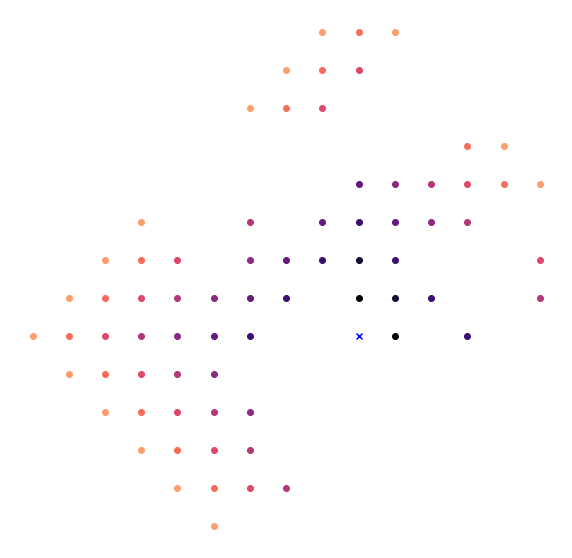

In [ ]:
from bokeh.palettes import Magma

fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(PV.iloc[100].N , PV.iloc[100].E, color = 'b', marker = 'x')

for i in range(9):
  ax.scatter(l[i].N , l[i].E, color = Magma[11][i], marker = 'o')

plt.axis('off')
plt.show()

In [ ]:
df = pd.concat([l[0], l[1]])

for i in l[2:]:
  df = pd.concat([df, i], axis=0)

In [ ]:
np.random.seed(42)
sample = df.sample(20)

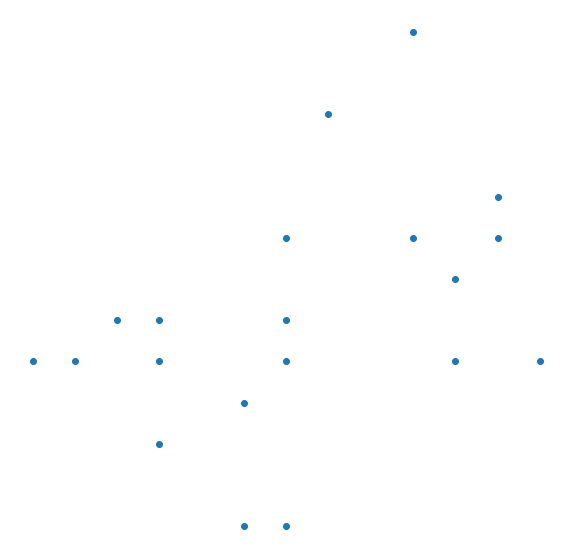

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(sample.N, sample.E)

plt.axis('off')
plt.show()

In [ ]:
sample.head()

,CELLCODE,Ph_count,N,E,Lat,Lng
99,1kmE4021N2577,11.0,2577.5,4021.5,46.240256,6.119278
93,1kmE4021N2571,10.0,2571.5,4021.5,46.186298,6.123170
87,1kmE4020N2576,13.0,2576.5,4020.5,46.230792,6.106993
101,1kmE4021N2581,5.0,2581.5,4021.5,46.276226,6.116678
96,1kmE4021N2574,14.0,2574.5,4021.5,46.213277,6.121226


## Series de tiempo de la producción PV

In [ ]:
# Creamos una lista vacia
df_list = []

# Año de inicio
ai = 2010
# Año de termino (maximo 2016)
at = 2016

# Iteramos sobre cada elemento del dataframe
  # la funcion iterrows nos permite iterar sobre renglones, devuelve dos elementos: [0] index, [1] dataframe 
  # Iniciamos el ciclo for
for i in sample.iterrows():
  # utilizamos la funcion get_pvgis_hourly de pvlib la cual nos regresa la serie de tiempo asociada a la producción PV 
  a = pvlib.iotools.get_pvgis_hourly(latitude = i[1].Lat, longitude =i[1].Lng, start=ai, end=at, pvcalculation=True, peakpower= 172.0)
  # utilizamos la funcion append de la lista para guardar el data frame
  df_list.append(a[0][['P','poa_direct','poa_sky_diffuse']])

el dataframe en este punto es la serie de tiempo por cada una de las estaciones, contiene 3 datos para cada intervalo de 1h estos son "P" Potencia PV, "poa_direct" es la irradianza directa y la "poa_sky_diffuse" es la irradinza horizontal

In [ ]:
max_values = []

for i in df_list:

  i.P = i.P/ i.P.max()
  i.poa_direct = i.poa_direct/ i.poa_direct.max()
  i.poa_sky_diffuse = i.poa_sky_diffuse/ i.poa_sky_diffuse.max()

  max_values.append(i.P.max())

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_list[1].iloc[12]

P                  0.088404
poa_direct         0.000000
poa_sky_diffuse    0.207792
Name: 2010-01-01 12:10:00+00:00, dtype: float64

# Manipulación de Datos

In [ ]:
# Guardamos los nombres de las estaciones en un array
stations = sample.index.values

display(stations)

array([ 99,  93,  87, 101,  96, 110, 148,  53, 114, 210,  73, 146, 134,
        52, 102, 150, 252,  94, 165, 111])

In [ ]:
# calculamos el número de observaciones, estas observaciones son cada hora de cada dia por 6 años
datos = len(df_list[0])

# creamos un ciclo for para una de las estaciones
for i in range(len(df_list)):
  # creamos una nueva columna para con la información original de la estación
  df_list[i]["region"] = [int(stations[i])]*datos
  #df_list[i]["Latitude"] = [df["Latitude"].iloc[i] for j in range(datos)]
  #df_list[i]["Longitude"] = [df["Longitude"].iloc[i] for j in range(datos)]
  #df_list[i]["Height"] = [df['Station height m. a. sea level'].iloc[i] for j in range(datos)]
  #df_list[i]['CoordinatesE'] = [df['CoordinatesE'].iloc[i] for j in range(datos)]
  #df_list[i]['CoordinatesN'] = [df['CoordinatesN'].iloc[i] for j in range(datos)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


observamos los nuevos elementos de la lista "df_list" cada uno es un dataframe correspondiente a una estación, con las observaciones hechas por hora durante 6 años

In [ ]:
# Creamos una nueva lista vacía
datos_finales = []

# Empezamos a iterar sobre el numero de observaciones
for i in range(len(df_list[0])):
  # En cada iteración creamos una lista vacía
  dat = []
  # Creamos una segunda iteración sobre cada una de las estaciones
  for j in range(len(df_list)):
    # Apendamos a la lista vacía generada la observación i, de la estación j
    dat.append(df_list[j].iloc[i])
  # Concatenamos cada observación de cada una de las estaciones como un nuevo dataframe 
  df_dat = pd.concat(dat, axis = 1).T
  # La columna region como int
  df_dat['region'] = df_dat['region'].astype('int64')
  # Appendamos cada dataframe a una nueva lista  
  datos_finales.append(df_dat)

El resultado es una lista de DataFrames, donde cada uno contiene las observaciones.

In [ ]:
datos_observados = []

for i in datos_finales:
  datos_observados.append((i.index[0] , i.reset_index().iloc[:,1:5].set_index('region')))

El resultado es una lista de tuples, donde la primera entrada contiene el dato temporal y la segunda entrada la observación espacial

In [ ]:
scaler = StandardScaler()

final_data = []

for i in datos_observados:
  data = i[1]
  names = data.index
  scaler.fit(data)
  scaled = scaler.transform(data)
  data_norm = pd.DataFrame(scaled)
  
  data_norm = data_norm.set_index(names)
  data_norm.columns = list(data.columns)
  final_data.append(( i[0], i[1] , data_norm))

In [ ]:
f = [i for i in final_data if (i[0].year == 2011 and i[0].month == 5 )]

f[12]

(Timestamp('2011-05-01 12:10:00+0000', tz='UTC'),
                P  poa_direct  poa_sky_diffuse
 region                                       
 99      0.834438    0.678294         0.508658
 93      0.800166    0.596576         0.610390
 87      0.834438    0.678294         0.508658
 101     0.868811    0.734851         0.404762
 96      0.834443    0.678294         0.508658
 110     0.839609    0.678294         0.508658
 148     0.876083    0.787949         0.370933
 53      0.866151    0.751941         0.407809
 114     0.839658    0.678294         0.508658
 210     0.876274    0.787949         0.370933
 73      0.866132    0.751941         0.407809
 146     0.885436    0.782847         0.351410
 134     0.872025    0.734851         0.404762
 52      0.866169    0.751941         0.407809
 102     0.868831    0.734851         0.404762
 150     0.876095    0.787949         0.370933
 252     0.873803    0.758586         0.299296
 94      0.800009    0.596576         0.610390
 165     0

# Exportación de Datos

Pickle, el mejor formato para almacenar timeseries en Python, pickle se utiliza para serializar y des serializar una estructura de objeto python. cualquier objeto en python se puede decapar para que se pueda guardar en disco.

In [ ]:
# De esta manera al momento de importar datos el primer elemento sera el dataframe con la información espacial de las
# plantas y el segundo serán las observaciones temporales

F = (sample , final_data, max_values)

In [ ]:
# Escribimos el archivo pickle 

# Datos de entrada
entrada = F

# Nombre del archivo de salida
salida = 'PV_2010_2016.pkl'

with open(salida , 'wb') as file:
  pickle.dump(entrada ,file)

In [ ]:
!cp PV_2010_2016.pkl "drive/Shareddrives/PV/ESP/datos"